In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import IPython.display as ipd
#import os
#model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models/'])
model_dir = "./models/"
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_weight_penalty, prune_plot
import copy
from tensorboardX import SummaryWriter
writer = SummaryWriter('tensorboard/run3/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()
use_cuda = torch.cuda.is_available()

#arguments
model_name = 'LeNet_300_100'
training_epochs=100
retraining_epochs=50
temp_list = [1, 5, 10, 15, 20, 25, 30]

## LeNet 300-100

### 1. Train Model

**Default Training**

Epoch: 10. Loss: 1.4920706748962402. Accuracy: 97.23
Epoch: 20. Loss: 1.4663395881652832. Accuracy: 97.51
Epoch: 30. Loss: 1.4619184732437134. Accuracy: 97.55
Epoch: 40. Loss: 1.461152195930481. Accuracy: 97.9
Epoch: 50. Loss: 1.4632068872451782. Accuracy: 97.87
Epoch: 60. Loss: 1.461687684059143. Accuracy: 97.92
Epoch: 70. Loss: 1.4611531496047974. Accuracy: 98.13
Epoch: 80. Loss: 1.4611505270004272. Accuracy: 98.18
Epoch: 90. Loss: 1.471567153930664. Accuracy: 98.03
Epoch: 100. Loss: 1.471567153930664. Accuracy: 98.16


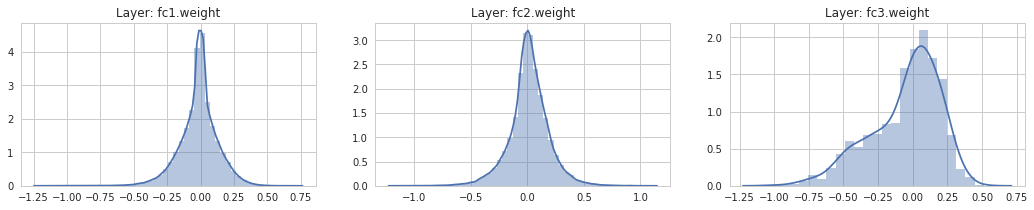

In [6]:
model = models.LeNet_300_100().cuda()
#print_dims(model)
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='original_model/'

for epoch in range(training_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
    writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
    writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
    for name, param in model.named_parameters():
        writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (epoch%20==19):
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
    
show_weights(model)
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

### 2. Re-train Model

**Temperature = 1**

Epoch: 10. Train CE Loss: 1.515, Train Accuracy: 98.800, Test CE Loss: 1.520, Test Accuracy: 97.810, Model L2: 19.320
Epoch: 20. Train CE Loss: 1.516, Train Accuracy: 98.780, Test CE Loss: 1.522, Test Accuracy: 97.640, Model L2: 18.818
Epoch: 30. Train CE Loss: 1.513, Train Accuracy: 98.865, Test CE Loss: 1.518, Test Accuracy: 97.910, Model L2: 18.723
Epoch: 40. Train CE Loss: 1.513, Train Accuracy: 99.008, Test CE Loss: 1.519, Test Accuracy: 97.880, Model L2: 18.721
Epoch: 50. Train CE Loss: 1.512, Train Accuracy: 98.983, Test CE Loss: 1.518, Test Accuracy: 97.780, Model L2: 18.702


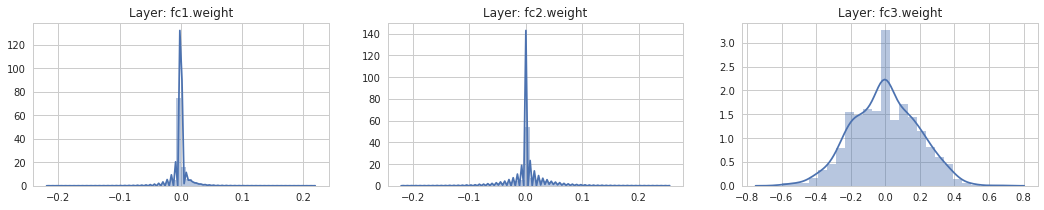

**Temperature = 5**

Epoch: 10. Train CE Loss: 1.518, Train Accuracy: 98.812, Test CE Loss: 1.522, Test Accuracy: 97.970, Model L2: 19.017
Epoch: 20. Train CE Loss: 1.517, Train Accuracy: 98.773, Test CE Loss: 1.522, Test Accuracy: 97.760, Model L2: 18.571
Epoch: 30. Train CE Loss: 1.515, Train Accuracy: 98.903, Test CE Loss: 1.521, Test Accuracy: 97.970, Model L2: 18.528
Epoch: 40. Train CE Loss: 1.516, Train Accuracy: 98.927, Test CE Loss: 1.522, Test Accuracy: 97.960, Model L2: 18.464
Epoch: 50. Train CE Loss: 1.515, Train Accuracy: 98.882, Test CE Loss: 1.520, Test Accuracy: 97.800, Model L2: 18.415


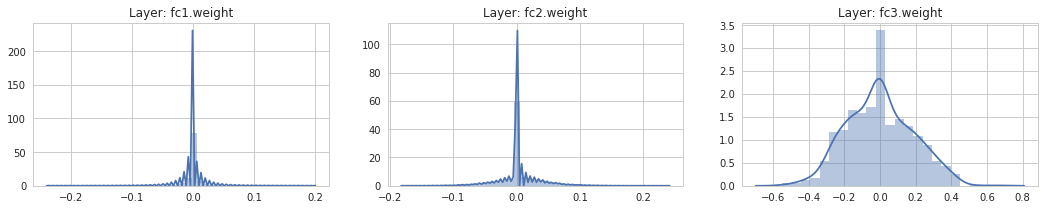

**Temperature = 10**

Epoch: 10. Train CE Loss: 1.537, Train Accuracy: 98.575, Test CE Loss: 1.540, Test Accuracy: 97.730, Model L2: 17.892
Epoch: 20. Train CE Loss: 1.535, Train Accuracy: 98.593, Test CE Loss: 1.538, Test Accuracy: 97.800, Model L2: 17.519
Epoch: 30. Train CE Loss: 1.536, Train Accuracy: 98.532, Test CE Loss: 1.540, Test Accuracy: 97.630, Model L2: 17.443
Epoch: 40. Train CE Loss: 1.538, Train Accuracy: 98.493, Test CE Loss: 1.541, Test Accuracy: 97.580, Model L2: 17.411
Epoch: 50. Train CE Loss: 1.538, Train Accuracy: 98.673, Test CE Loss: 1.542, Test Accuracy: 97.690, Model L2: 17.377


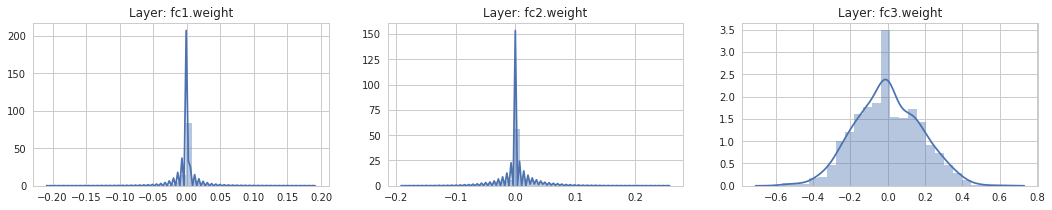

**Temperature = 15**

Epoch: 10. Train CE Loss: 1.585, Train Accuracy: 98.198, Test CE Loss: 1.584, Test Accuracy: 97.590, Model L2: 16.284
Epoch: 20. Train CE Loss: 1.585, Train Accuracy: 98.177, Test CE Loss: 1.584, Test Accuracy: 97.480, Model L2: 15.978
Epoch: 30. Train CE Loss: 1.582, Train Accuracy: 98.258, Test CE Loss: 1.581, Test Accuracy: 97.500, Model L2: 15.964
Epoch: 40. Train CE Loss: 1.584, Train Accuracy: 98.250, Test CE Loss: 1.584, Test Accuracy: 97.530, Model L2: 15.944
Epoch: 50. Train CE Loss: 1.580, Train Accuracy: 98.203, Test CE Loss: 1.580, Test Accuracy: 97.540, Model L2: 15.896


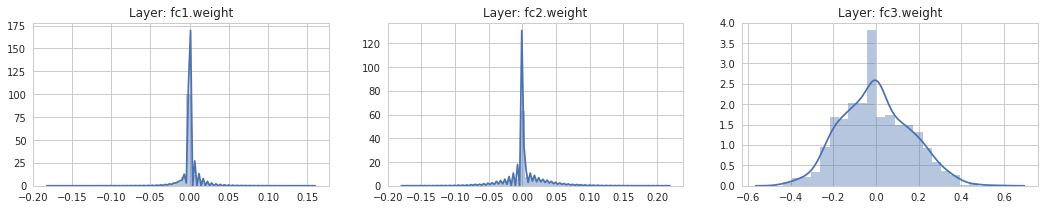

**Temperature = 20**

Epoch: 10. Train CE Loss: 1.660, Train Accuracy: 97.843, Test CE Loss: 1.657, Test Accuracy: 97.360, Model L2: 14.856
Epoch: 20. Train CE Loss: 1.658, Train Accuracy: 97.917, Test CE Loss: 1.655, Test Accuracy: 97.410, Model L2: 14.569
Epoch: 30. Train CE Loss: 1.655, Train Accuracy: 97.865, Test CE Loss: 1.653, Test Accuracy: 97.320, Model L2: 14.516
Epoch: 40. Train CE Loss: 1.658, Train Accuracy: 97.885, Test CE Loss: 1.655, Test Accuracy: 97.310, Model L2: 14.478
Epoch: 50. Train CE Loss: 1.662, Train Accuracy: 98.075, Test CE Loss: 1.660, Test Accuracy: 97.390, Model L2: 14.466


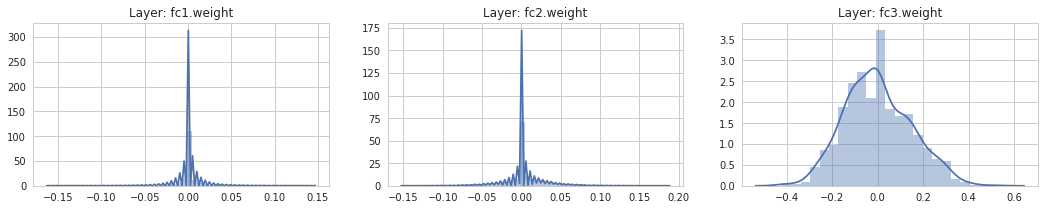

**Temperature = 25**

Epoch: 10. Train CE Loss: 1.745, Train Accuracy: 97.605, Test CE Loss: 1.740, Test Accuracy: 97.220, Model L2: 13.803
Epoch: 20. Train CE Loss: 1.740, Train Accuracy: 97.717, Test CE Loss: 1.735, Test Accuracy: 97.250, Model L2: 13.393
Epoch: 30. Train CE Loss: 1.739, Train Accuracy: 97.607, Test CE Loss: 1.734, Test Accuracy: 97.170, Model L2: 13.393
Epoch: 40. Train CE Loss: 1.740, Train Accuracy: 97.518, Test CE Loss: 1.735, Test Accuracy: 97.130, Model L2: 13.372
Epoch: 50. Train CE Loss: 1.738, Train Accuracy: 97.733, Test CE Loss: 1.734, Test Accuracy: 97.350, Model L2: 13.344


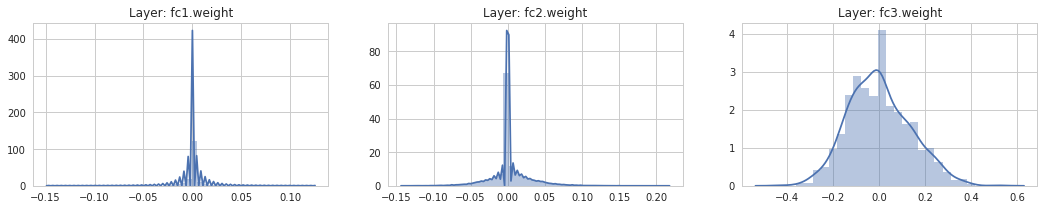

**Temperature = 30**

Epoch: 10. Train CE Loss: 1.826, Train Accuracy: 97.295, Test CE Loss: 1.821, Test Accuracy: 97.060, Model L2: 12.944
Epoch: 20. Train CE Loss: 1.821, Train Accuracy: 97.343, Test CE Loss: 1.815, Test Accuracy: 96.960, Model L2: 12.456
Epoch: 30. Train CE Loss: 1.819, Train Accuracy: 97.100, Test CE Loss: 1.814, Test Accuracy: 96.870, Model L2: 12.423
Epoch: 40. Train CE Loss: 1.818, Train Accuracy: 97.138, Test CE Loss: 1.813, Test Accuracy: 96.790, Model L2: 12.403
Epoch: 50. Train CE Loss: 1.816, Train Accuracy: 97.368, Test CE Loss: 1.812, Test Accuracy: 97.110, Model L2: 12.400


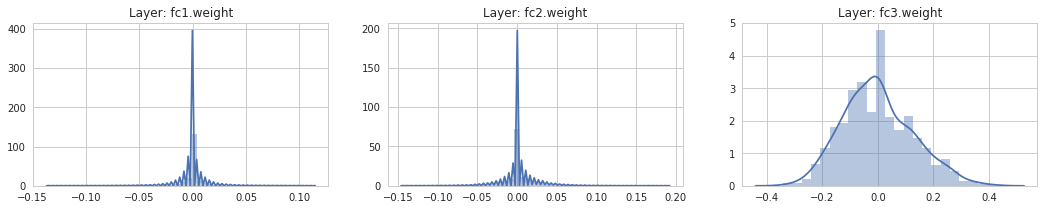

In [7]:
#Get KD Targets   
for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
    kd_outputs = model.kd_targets(train_data_full,T=temp)
    kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
    train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "retraining_model_T_{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_data_full, test_labels_full, model_kd)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_kd)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%20==19):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

### 3. Prune Model

**Temperature = 1**

Train CE Loss: 1.813, Train Accuracy: 94.687, Test CE Loss: 1.809, Test Accuracy: 94.020, Model L2: 16.570, Parameters Pruned: 235920/266610 - 88.489%
Train CE Loss: 1.859, Train Accuracy: 88.570, Test CE Loss: 1.855, Test Accuracy: 88.310, Model L2: 16.365, Parameters Pruned: 226270/266610 - 84.869%


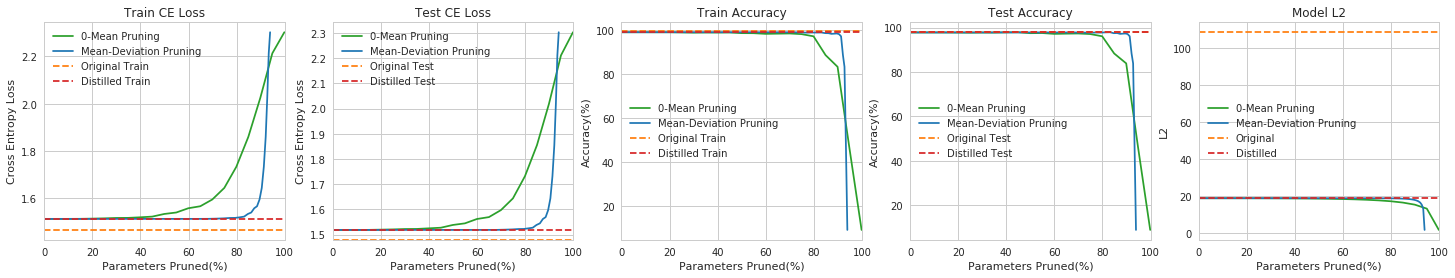

**Temperature = 5**

Train CE Loss: 1.811, Train Accuracy: 93.205, Test CE Loss: 1.807, Test Accuracy: 92.730, Model L2: 16.337, Parameters Pruned: 235853/266610 - 88.464%
Train CE Loss: 1.900, Train Accuracy: 81.735, Test CE Loss: 1.896, Test Accuracy: 81.840, Model L2: 16.000, Parameters Pruned: 226270/266610 - 84.869%


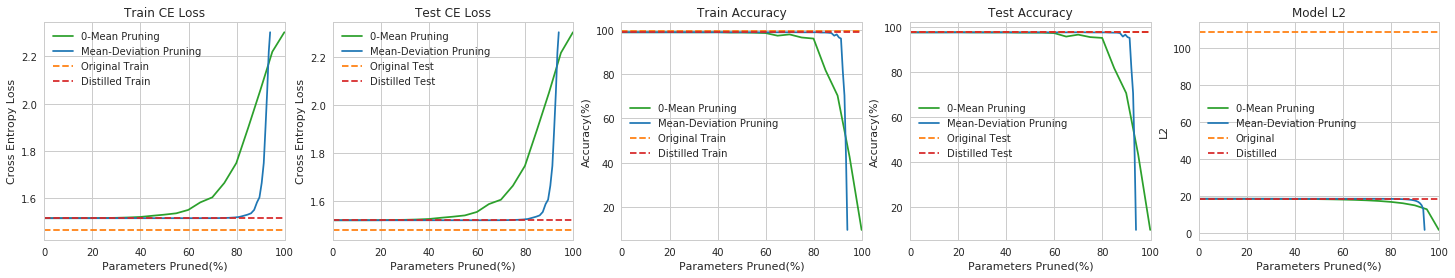

**Temperature = 10**

Train CE Loss: 1.881, Train Accuracy: 84.928, Test CE Loss: 1.877, Test Accuracy: 85.110, Model L2: 15.407, Parameters Pruned: 235796/266610 - 88.442%
Train CE Loss: 1.933, Train Accuracy: 85.282, Test CE Loss: 1.928, Test Accuracy: 85.260, Model L2: 15.173, Parameters Pruned: 226270/266610 - 84.869%


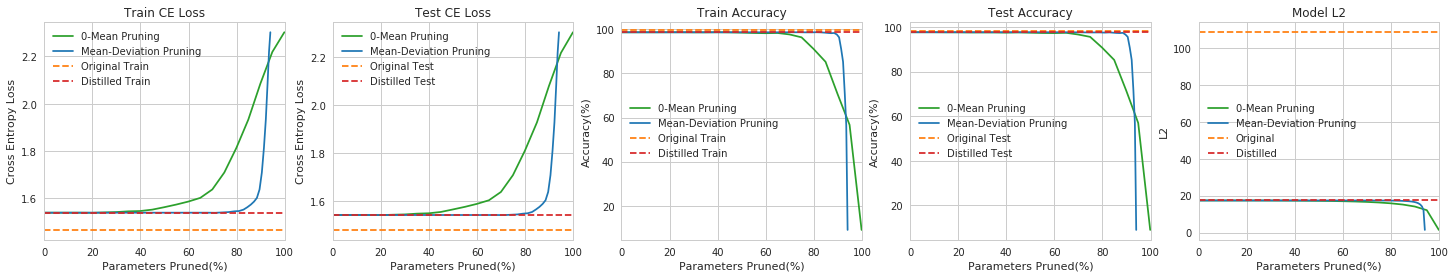

**Temperature = 15**

Train CE Loss: 1.934, Train Accuracy: 84.722, Test CE Loss: 1.930, Test Accuracy: 84.290, Model L2: 14.044, Parameters Pruned: 235037/266610 - 88.158%
Train CE Loss: 1.998, Train Accuracy: 72.022, Test CE Loss: 1.995, Test Accuracy: 71.980, Model L2: 13.821, Parameters Pruned: 226270/266610 - 84.869%


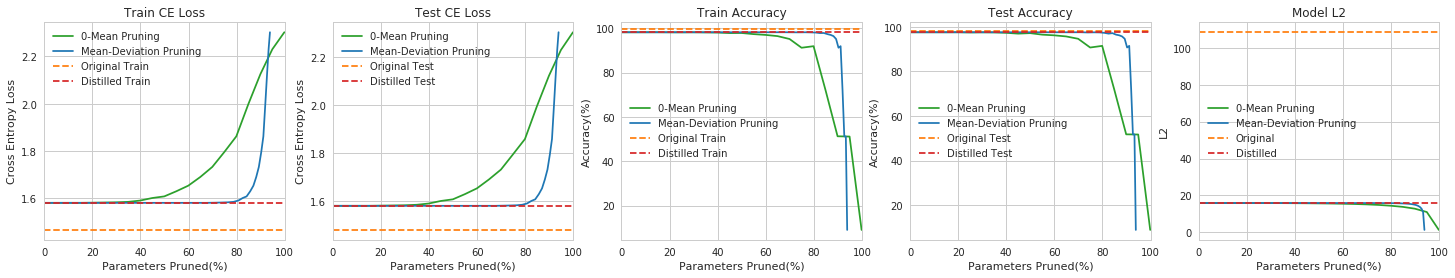

**Temperature = 20**

Train CE Loss: 2.006, Train Accuracy: 84.067, Test CE Loss: 2.004, Test Accuracy: 84.280, Model L2: 12.811, Parameters Pruned: 236209/266610 - 88.597%
Train CE Loss: 2.032, Train Accuracy: 85.308, Test CE Loss: 2.029, Test Accuracy: 85.650, Model L2: 12.667, Parameters Pruned: 226270/266610 - 84.869%


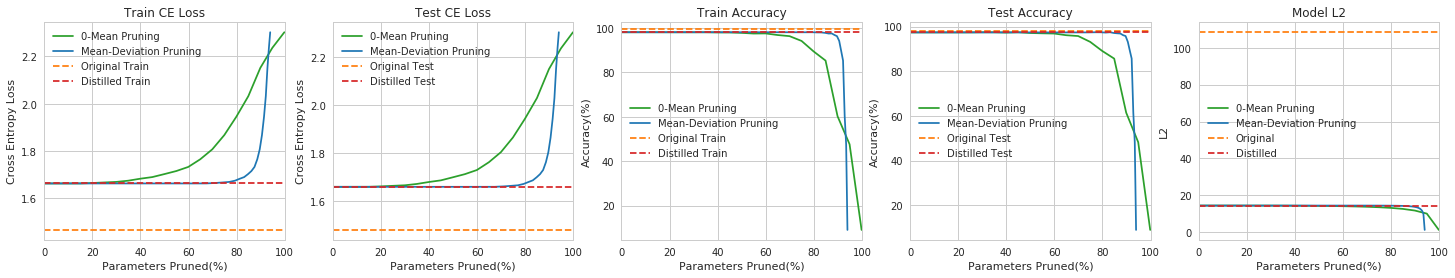

**Temperature = 25**

Train CE Loss: 2.050, Train Accuracy: 84.558, Test CE Loss: 2.047, Test Accuracy: 84.450, Model L2: 11.820, Parameters Pruned: 234749/266610 - 88.050%
Train CE Loss: 2.081, Train Accuracy: 75.823, Test CE Loss: 2.079, Test Accuracy: 76.280, Model L2: 11.685, Parameters Pruned: 226270/266610 - 84.869%


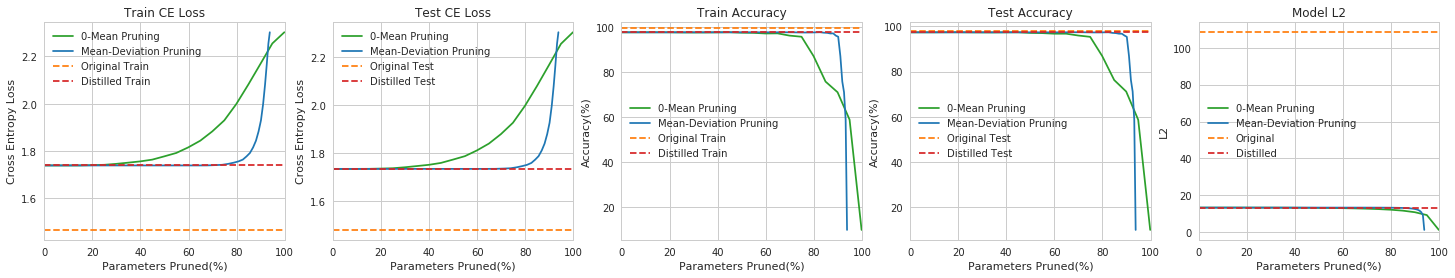

**Temperature = 30**

Train CE Loss: 2.097, Train Accuracy: 84.898, Test CE Loss: 2.094, Test Accuracy: 85.010, Model L2: 10.974, Parameters Pruned: 234423/266610 - 87.927%
Train CE Loss: 2.126, Train Accuracy: 78.197, Test CE Loss: 2.123, Test Accuracy: 78.590, Model L2: 10.827, Parameters Pruned: 226270/266610 - 84.869%


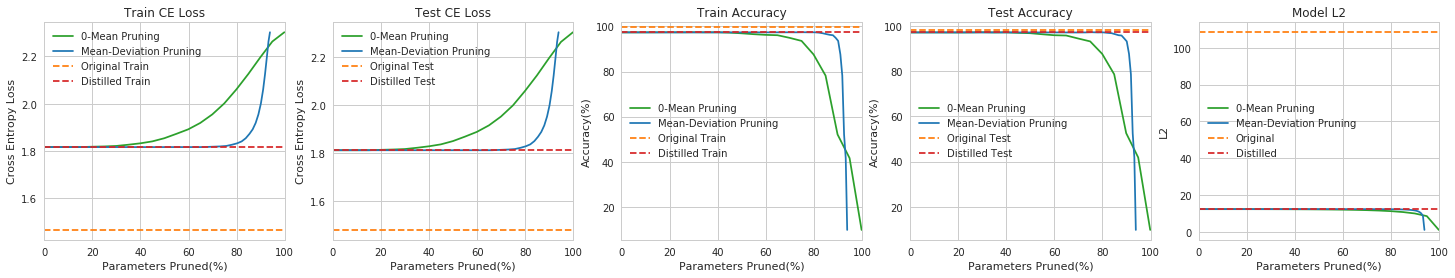

In [4]:
#Original Model
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
test_acc_o = test_accuracy(test_data_full, test_labels_full, model)
train_acc_o = test_accuracy(train_data_full, train_labels_full, model)
weight_penalty_o = get_weight_penalty(model)
compress_res = {}

for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    graph_title = "compressed_model_T_{}/".format(temp)
    #Retrained Model
    model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e50.m'.format(temp)).cuda()
    test_acc_kd = test_accuracy(test_data_full, test_labels_full, model_kd)
    train_acc_kd = test_accuracy(train_data_full, train_labels_full, model_kd)
    weight_penalty_kd = get_weight_penalty(model_kd)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
    writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
    writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
    writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)
    
    model_c = models.LeNet_300_100().cuda()
    pruner = model_prune(model_kd.state_dict())
    deviation_list = [x/10.0 for x in range(0,21)]
    percentile_list = range(0,101,5)
    
    
    dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
    for i,lim in enumerate(deviation_list):
        model_c.load_state_dict(pruner.deviation_prune(lim))
        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)

        dev_res['train ce'].append(train_acc[1])
        dev_res['test ce'].append(test_acc[1])
        dev_res['train acc'].append(train_acc[0])
        dev_res['test acc'].append(test_acc[0])
        dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        dev_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)

        if(i==13):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
    
    perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 
    for i,lim in enumerate(percentile_list):
        model_c.load_state_dict(pruner.percentile_prune(lim))

        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)
        perc_res['train ce'].append(train_acc[1])
        perc_res['test ce'].append(test_acc[1])
        perc_res['train acc'].append(train_acc[0])
        perc_res['test acc'].append(test_acc[0])
        perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        perc_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
        
        if(i==17):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
            
    prune_plot(temp, dev_res, perc_res, test_acc_o, train_acc_o, weight_penalty_o, test_acc_kd, train_acc_kd, weight_penalty_kd)
    #t_res={} 
    #t_res['dev']=dev_res
    #t_res['perc']=perc_res
    #compress_res[temp]=t_res